In [2]:
import gc
import json
import pickle as pk
import random
import re
import time
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pytesseract
import requests
import torch
from IPython.display import HTML
from matplotlib import animation
from transformers import (
    AutoModel,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    pipeline,
)
from vidaug import augmentors as va

In [3]:
with open("./data/data_sampled_smol.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)

X_data[0]

'/home/lehoangchibach/Documents/Code/gif_analytics/templates/template_examples/a6539c35ec07965956f1de7b3ec36971_416346667.gif'

In [33]:
NUM_FRAMES = 5
IMAGE_SIZE = (224, 224)


def _input_processor(video_path: str) -> np.ndarray:
    frames = []
    cap = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        raise ValueError("Could not read frames from video file")

    # Calculate frame indices to extract
    frame_indices = [
        i * (total_frames - 1) // (NUM_FRAMES - 1) for i in range(NUM_FRAMES)
    ]

    for frame_idx in frame_indices:
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read frame
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, IMAGE_SIZE)

            frames.append(frame_rgb)

    # Release video capture object
    cap.release()

    while len(frames) < 5:
        frames.append(frames[-1])

    # return np.stack(frames)
    video_data = np.stack(frames) / 255.0
    return video_data.astype(np.float32)


def input_processor(video_path: str) -> np.ndarray:
    frames = []
    cap = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames <= 0:
        raise ValueError("Could not read frames from video file")

    # Calculate frame indices to extract
    frame_indices = [
        i * (total_frames - 1) // (NUM_FRAMES - 1) for i in range(NUM_FRAMES)
    ]

    for frame_idx in frame_indices:
        # Set frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        # Read frame
        ret, frame = cap.read()
        if ret:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, IMAGE_SIZE)

            frames.append(frame_rgb)

    # Release video capture object
    cap.release()

    while len(frames) < 5:
        frames.append(frames[-1])

    seq = va.Sequential(
        [
            va.Pepper(),
            va.RandomShear(x=0.05, y=0.05),
            va.RandomTranslate(x=25, y=25),
            va.RandomRotate(20),
            va.Sometimes(0.5, va.HorizontalFlip()),
        ]
    )

    frames = seq(frames)
    video_data = np.stack(frames)
    return video_data.astype(np.float32)


def draw_video(video, interval=250):
    fig = plt.figure()
    im = plt.imshow(video[0, :, :, :])

    plt.close()  # this is required to not display the generated image

    def init():
        im.set_data(video[0, :, :, :])

    def animate(i):
        im.set_data(video[i, :, :, :])
        return im

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=video.shape[0], interval=interval
    )
    return HTML(anim.to_html5_video())

In [41]:
# array_2d = data.reshape(-1, data.shape[-1])
# np.savetxt('array_float32.txt', array_2d, fmt='%.6f')

In [38]:
data = input_processor(X_data[0])
draw_video(data, 200)

In [35]:
?va.RandomRotate

Init signature: va.RandomRotate(degrees)
Docstring:     
Rotate video randomly by a random angle within given boundsi.

Args:
    degrees (sequence or int): Range of degrees to randomly
    select from. If degrees is a number instead of sequence
    like (min, max), the range of degrees, will be
    (-degrees, +degrees).
File:           ~/anaconda3/envs/gif_analytic/lib/python3.11/site-packages/vidaug/augmentors/affine.py
Type:           type
Subclasses:     

In [37]:
sometimes = lambda aug: va.Sometimes(
    0.5, aug
)  # Used to apply augmentor with 50% probability
seq = va.Sequential(
    [
        va.Pepper(),
        va.RandomShear(x=0.05, y=0.05),
        va.RandomTranslate(x=25, y=25),
        va.RandomRotate(20),
        # sometimes(
        #     va.HorizontalFlip()
        # ),
    ]
)

ag = np.stack(seq(data))
draw_video(ag)

In [25]:
def clean_up(text):
    messages = [
        {
            "role": "system",
            "content": """
         You are receiving extracted text from a meme. 
         Perform clean up, correct on text and remove any gibberish in it. You are allowed to change very small typo to make the sentence understandable. 
         Do not add new words or sentences. Do not change the structure of the text.
         Return only the cleaned up text. If you are not able to clean it up, return empty string only.
         Your response must be in the following json format.
         =====
         Return json format:
         {
         "text": "the clean up text here"
         }
        """,
        },
        {"role": "user", "content": text},
    ]
    response = requests.post(
        "http://localhost:11434/api/chat",
        json={"model": "llama3.2:3b", "messages": messages, "stream": False},
    )

    if response.status_code == 200:
        content = response.json()["message"]["content"]
        try:
            return json.loads(content)["text"]
        except Exception:
            return clean_up(text)
    else:
        print(f"Error: {response.status_code} - {response.text}")

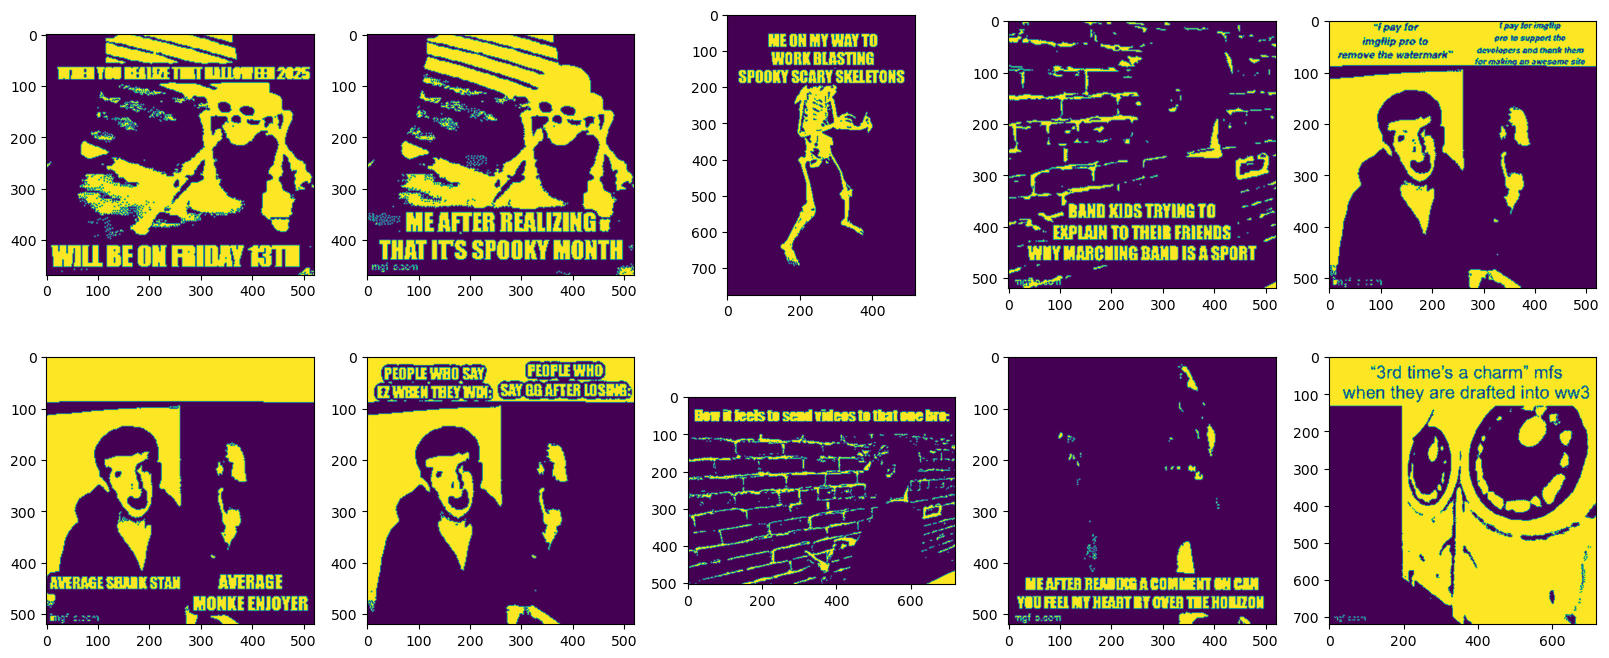

['WILL BE ON FRIDAY 13TH',
 'if\n\n-MEAFTER REALIZING ©\n‘THAT ITS SPOOKY MONTH',
 'ME ON MY WAY TO\nWORK BLASTING\nSPOOKY SCARY SKELETONS',
 '~ ee Novtue\n- “= ea\n\nae a Oe . eo\nPe ads\n= co — ca\n\na BAHD KIDS TRYING TO TA\n\n~"*. EXPLAIN TO THEIR FRIENDS |\n“why MARCHING BAMB IS A SPORT\n\nnofpecott ~\n\na',
 'pay for\nimgtlip pro ta\nremove the watermark”\n\npro to support tho\ndevelopers and thank them',
 '',
 '',
 'Hew ft fecis te Send videos te that one bre-\npre diam nee I oe',
 'ME AFTER REABING A COMMENT GH CAN\nYau Re ——_— —\n\nngf o.2.',
 '“3rd time’s a charm” mfs\nwhen they are drafted into ww3']

In [28]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
texts = []
for i, ax in enumerate(axs.flat):
    data = input_processor(X_data[i])
    image = data[0]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    image = cv2.resize(image, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    # Apply the kernel to the image
    # image = cv2.filter2D(image, -1, kernel)

    ax.imshow(image)
    custom_config = r"--oem 3 --psm 3"
    text = pytesseract.image_to_string(image, lang="eng", config=custom_config).strip()
    # text = clean_up(text)
    texts.append(text)

plt.show()
texts

In [13]:
text

'WILL BE ON FRIDAY 1378.'